In [16]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Conv2D, Dense, Dropout, MaxPooling2D, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from xgboost import XGBClassifier

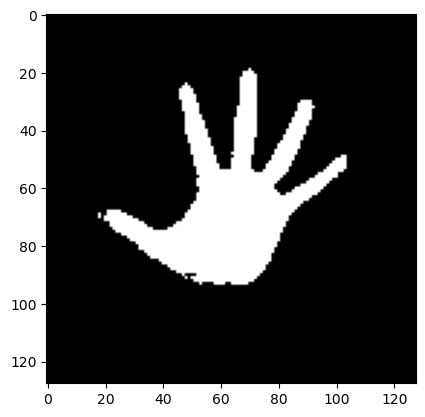

In [3]:
img_path = 'Ex_Files_Computer_Vision_Deep_Dive_in_Python/fingers/test/000e7aa6-100b-4c6b-9ff0-e7a8e53e4465_5L.png'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

_, img_thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

plt.imshow(img_thresh, cmap='gray')

In [4]:
path = 'Ex_Files_Computer_Vision_Deep_Dive_in_Python/fingers/'
folders = ['train','test']
classes = ['0','1','2','3','4','5']

images = []
labels = []

for folder in folders:
    folder_dir = os.path.join(path,folder)
    for file in os.listdir(folder_dir):
        img_path = os.path.join(folder_dir,file)
        
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        ## no need to resize, all 128x128
        
        img_thresh = np.expand_dims(img, axis=-1)
        
        label = int(file.split('_')[-1][0])
        
        images.append(img_thresh)
        labels.append(label)
        

images = np.array(images)
labels = np.array(labels)
    
images.shape

(21600, 128, 128, 1)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = 42, shuffle=True)

print(x_train.shape)
print(x_test.shape)

(17280, 128, 128, 1)
(4320, 128, 128, 1)


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

train_data_augmentation = ImageDataGenerator(rescale = 1/255,rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

test_data_augmentation = ImageDataGenerator(rescale = 1/255)

train_gen = train_data_augmentation.flow(x_train,y_train,batch_size = 32, shuffle=True)
test_gen = test_data_augmentation.flow(x_test,y_test,batch_size = 32)

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# use input tensors for tl
input_tensor = Input(shape=(128, 128, 1))

# use Keras Functional API to assist
x = Conv2D(32, (3,3), activation='relu', padding='same')(input_tensor)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Flatten()(x)


model = Model(inputs=input_tensor, outputs=x)

model.summary()

# feature extraction
feature_extractor = Model(inputs=model.input, outputs=model.output)

# extraction summary
feature_extractor.summary()


Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 16384)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,744 (217.75 KB)

 Trainable params: 55,744 (217.75 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 16384)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,744 (217.75 KB)

 Trainable params: 55,744 (217.75 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# feature extraction
X_train_features = feature_extractor.predict(x_train)

X_test_features = feature_extractor.predict(x_test)

540/540 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step


In [21]:
xgb_model = XGBClassifier()

# fitting model
xgb_model.fit(X_train_features, y_train)

# prediction test
y_train_pred = xgb_model.predict(X_train_features)
y_test_pred = xgb_model.predict(X_test_features)

In [23]:
# Evaluate the model
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Train Accuracy: 1.0000
Test Accuracy: 1.0000


In [29]:
# testing an image

image_path = 'Ex_Files_Computer_Vision_Deep_Dive_in_Python/testingImages/2018-10-29-open-hand.jpg'
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (128, 128))
img = np.expand_dims(img, axis=-1)
img = np.expand_dims(img, axis=0)
img = img / 255.0

In [30]:
# extracting features for image
extracted_features = feature_extractor.predict(img)

predicted_class = xgb_model.predict(extracted_features)
print("Predicted class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted class: [0]
